In [28]:
import numpy as np
from PIL import Image
import cv2
import glob
import os
from math import ceil
import matplotlib.pyplot as plt
import random
import shutil
import json

# Verify number of classes in json files

In [18]:
json_directory = r"SVF/json_labelled_files"
json_files = [os.path.join(json_directory,fp) for fp in os.listdir(json_directory)]
print(json_files)
def get_classes(json_files):
    classes_list = []
    for f in json_files:
        with open(f,'r') as file:
            data = json.load(file)
            classes = list(set([s['label'] for s in data['shapes']]))
            for c in classes:
                classes_list.append(c)
    
    return list(set(classes_list))

get_classes(json_files)

['SVF/json_labelled_files\\LCZ1_Compassvale_Site1_SVF.json', 'SVF/json_labelled_files\\LCZ1_Compassvale_Site2_SVF.json', 'SVF/json_labelled_files\\LCZ1_Compassvale_Site3_SVF.json', 'SVF/json_labelled_files\\LCZ1_Dawson_Site1_SVF.json', 'SVF/json_labelled_files\\LCZ2_Geylang_Site1_SVF.json', 'SVF/json_labelled_files\\LCZ2_Geylang_Site2_SVF.json', 'SVF/json_labelled_files\\LCZ4_BraddelView_Site2_SVF.json', 'SVF/json_labelled_files\\LCZ8_Tuas_Site3_SVF.json', 'SVF/json_labelled_files\\LCZA_MacRitchie_Site1_SVF.json', 'SVF/json_labelled_files\\LCZA_MacRitchie_Site3_SVF.json']


['sky']

# Prepare dataset for labelme

In [19]:
# shutil.copyfile(src_fp,dst_fp)
def prepare_annotated_data(json_files,dir_name = "data_annotated"):
    for f in json_files:
        with open(f,'r') as file:
            data = json.load(file)
        json_fp = os.path.basename(f)
        img_fp = data['imagePath']
        save_dir = os.path.join(os.getcwd(),dir_name)
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        img_dir = os.path.join(os.getcwd(),"SVF","SVF_photos")
        json_dir = os.path.join(os.getcwd(),"SVF","json_labelled_files")
        # copy json file
        shutil.copyfile(os.path.join(json_dir,json_fp),os.path.join(save_dir,json_fp))
        # copy JPEG file
        shutil.copyfile(os.path.join(img_dir,img_fp),os.path.join(save_dir,img_fp))
    return
# prepare_annotated_data(json_files)

# Create SVF mask

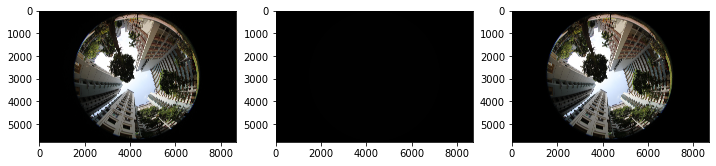

In [29]:
def image_to_array(fp):
    return np.asarray(Image.open(fp))

def circular_mask(img, save_dir=None):
    """ 
    create circular mask for image
    exports an RGB binary mask
    """
    nrow, ncol = img.shape[0], img.shape[1]
    radius = nrow//2
    mask = np.zeros_like(img)
    mask = cv2.circle(mask, (ncol//2,nrow//2), radius, (1,1,1), -1)

    fig, axes = plt.subplots(1,3,figsize=(12,5))
    axes[0].imshow(img)
    axes[1].imshow(mask,vmin=0,vmax=1)
    img_copy = img.copy()
    # img_copy[img_copy>1] = 255
    axes[2].imshow(img_copy*mask)
    plt.show()

    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        
        # save mask
        img_save = Image.fromarray(mask)
        img_save.save(os.path.join(save_dir,"SVF_mask.png"))
    return

x = image_to_array(r"data_dataset_voc/JPEGImages/LCZ1_Compassvale_Site1_SVF.jpg")
# circular_mask(x,os.getcwd())

In [2]:
def pad_images(img):
    nrow,ncol = img.shape[0],img.shape[1]
    if ncol > 512:
        raise ValueError("Img col is > 512!")
    if len(img.shape) == 3:
        pad_img = np.zeros((512,512,3))
        pad_img[:,:ncol,:] = img
        pad_img = pad_img.astype(np.uint8)
    else:
        pad_img = np.zeros((512,512))
        pad_img[:,:ncol] = img
        pad_img = pad_img.astype(np.uint8)
        if np.sum(pad_img) > 255 and np.sum(pad_img)/(512*512*255) < 0.05:
            pad_img = np.zeros((512,512)).astype(np.uint8)
        
    return pad_img#.astype(np.uint8)

def cut_into_512(img):
    nrow,ncol = img.shape[0],img.shape[1]
    # if len(img.shape) == 2:
    #     img = np.where(img>0,0,255).astype(np.uint8)
        # print("Changed into b&w")
    if ncol > 512:
        cut_images = []
        for i in range(0,nrow,512):
            for j in range(0,ncol, 512):
                if len(img.shape) == 3:
                    if j+512 <= ncol:
                        cut_images.append(img[i:i+512,j:j+512,:])
                    else:
                        padded_img = pad_images(img[i:i+512,j:ncol,:])
                        cut_images.append(padded_img)
                else:
                    if j+512 <= ncol:
                        cut_images.append(img[i:i+512,j:j+512])
                    else:
                        padded_img = pad_images(img[i:i+512,j:ncol])
                        cut_images.append(padded_img)
    else:
        cut_images = None
        print("ncol is already 512!")
    return cut_images

def save_imgs(cut_img_list,directory):
    for i,img in enumerate(cut_img_list):
        img_name = join(directory,"output{}.png".format(i))
        img = PIL.Image.fromarray(img)
        img.save(img_name)
    return


(1024, 8528, 3)
34
(1024, 8528)
34
(512, 512)
2 0


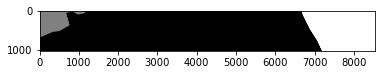

In [5]:
img = np.asarray(PIL.Image.open(rgb_img_fp[4]))
print(img.shape)
cut_img = cut_into_512(img)
print(len(cut_img))
img.shape

masked_img = np.asarray(PIL.Image.open(masked_img_fp[4]))
# masked_img = np.asarray(PIL.Image.open(r"masked_img_voc\SegmentationClassPNG\2021_08_25_10-32-33_rgb_image_line_00_546_1317.png"))
print(masked_img.shape)
cut_masked_img = cut_into_512(masked_img)
print(len(cut_masked_img))
print(cut_masked_img[0].shape)
plt.figure()
plt.imshow(masked_img,cmap='gray')
print(np.max(masked_img),np.min(masked_img))

In [6]:
# save_imgs(cut_img,r"masked_img_cut\JPEGImages")

1.0
0.43888092041015625
0.04779052734375
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.59210205078125
2.0
2.0
0.0
0.14669036865234375
9.1552734375e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.482177734375
1.9993133544921875
2.0
0.0


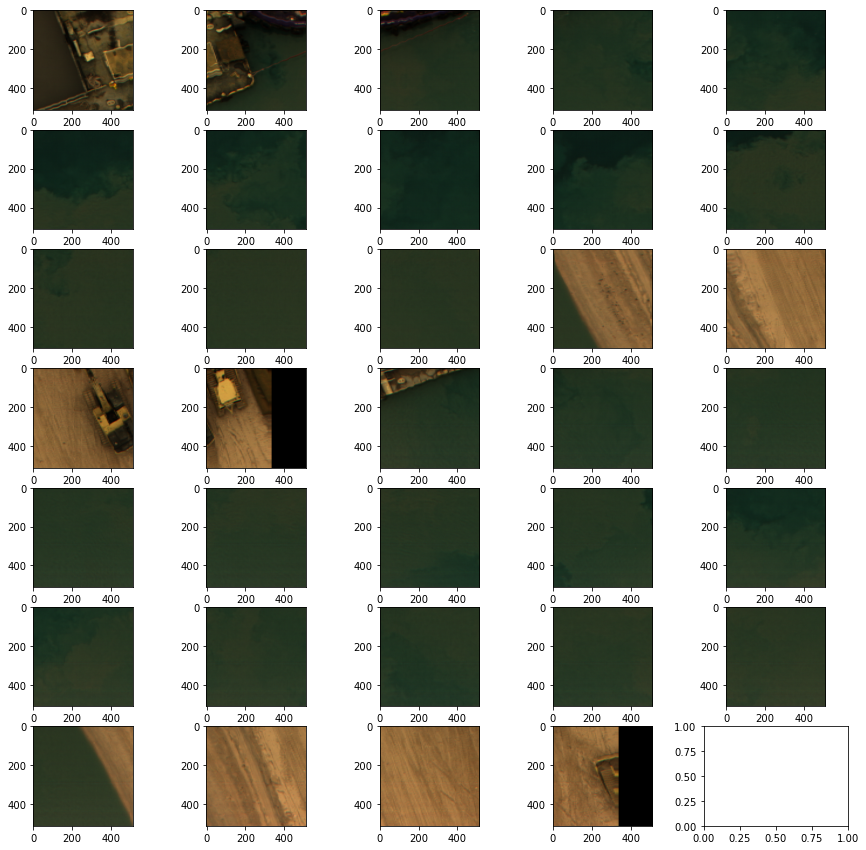

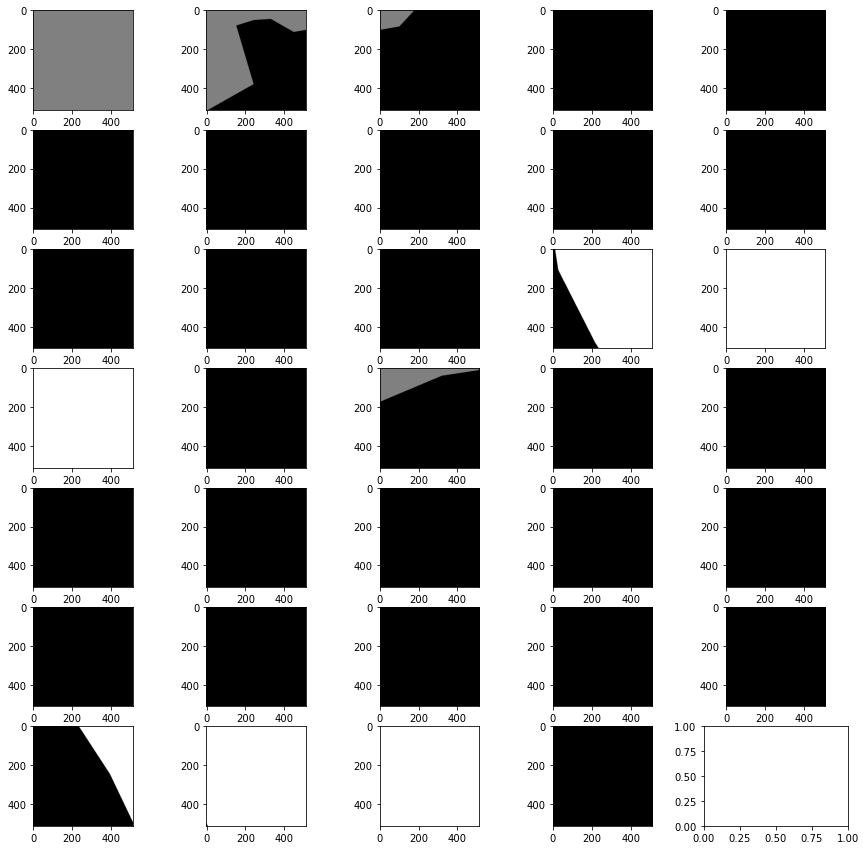

In [7]:
def preview_cut_img(cut_img_list):
    ncol = 5
    nrow = int(ceil(len(cut_img_list)/ncol))
    fig,axes = plt.subplots(nrow,ncol,figsize = (15,15))
    for img, ax in zip(cut_img_list,axes.flatten()):
        if len(img.shape) == 3:
            ax.imshow(img)
            
        else:
            ax.imshow(img,cmap='gray',vmin=0,vmax=2)
            print(np.mean(img))

    return
preview_cut_img(cut_img)
preview_cut_img(cut_masked_img)

2070


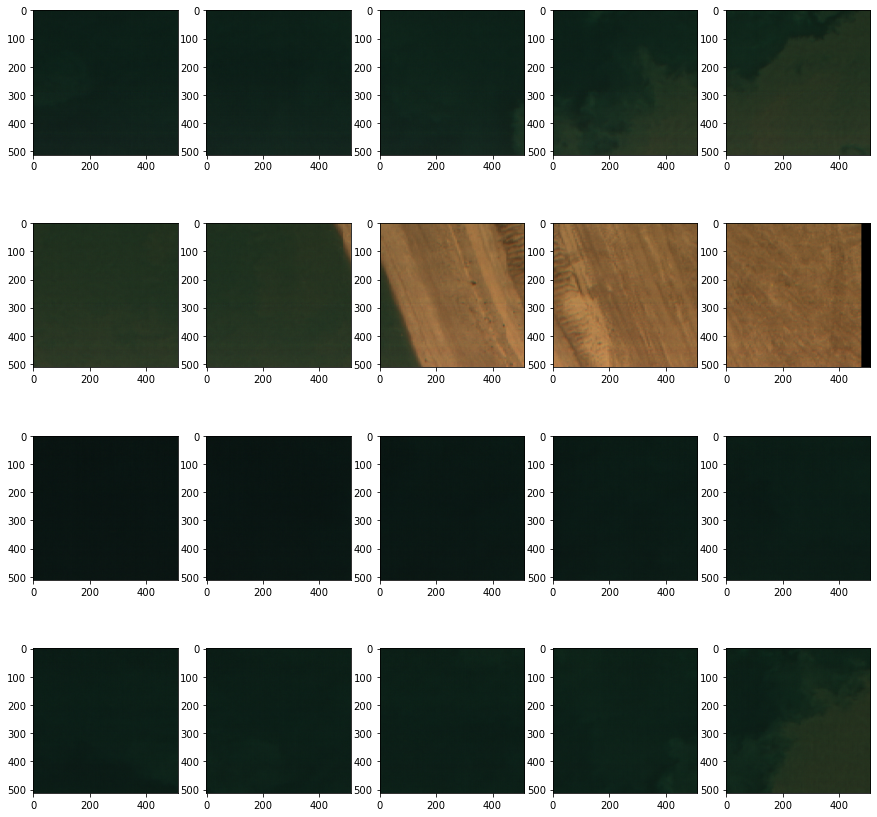

In [8]:
cut_imges = []
for f in rgb_img_fp:
# for f in masked_img_fp:
    img = np.asarray(PIL.Image.open(f))
    cut_imges_list = cut_into_512(img)
    # print(len(cut_imges_list))
    for i in cut_imges_list:
        cut_imges.append(i)

print(len(cut_imges))
preview_cut_img(cut_imges[40:60])

In [9]:
cut_masked_imges = []
# for f in rgb_img_fp:
for f in masked_img_fp:
    img = np.asarray(PIL.Image.open(f))
    cut_masked_imges_list = cut_into_512(img)
    # print(len(cut_masked_imges_list))
    for i in cut_masked_imges_list:
        cut_masked_imges.append(i)

len(cut_masked_imges)

2070

0.0
0.0
0.0
0.0
0.0
0.0
0.02378082275390625
1.7704238891601562
2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


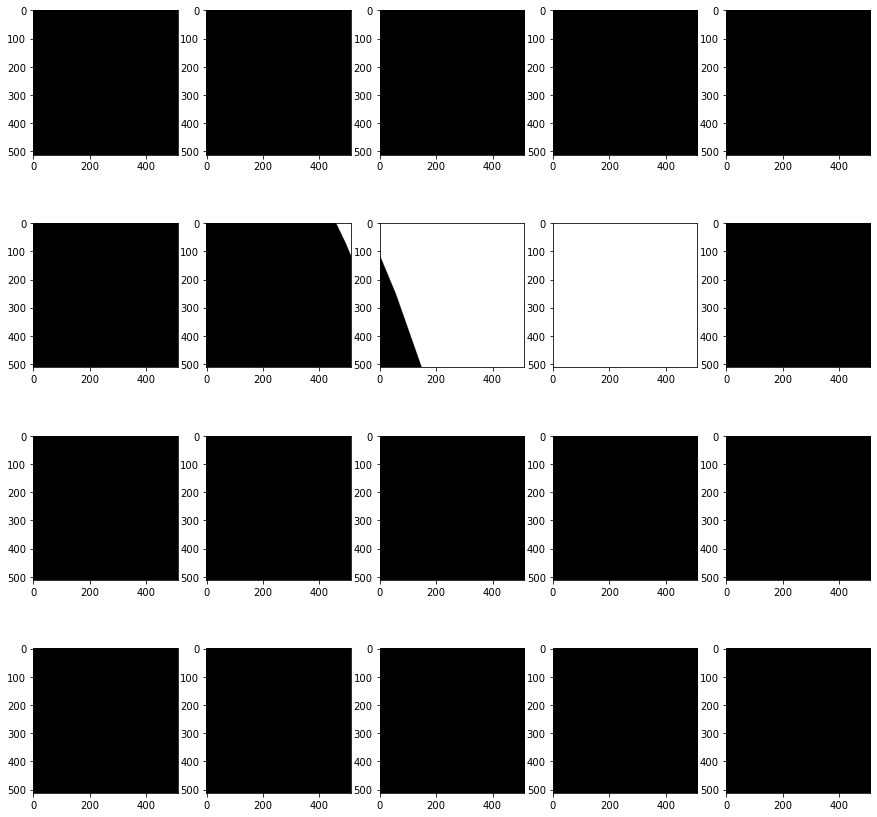

In [10]:
preview_cut_img(cut_masked_imges[40:60])

In [12]:
random_train = []
train_directory_images = r"rgb_train\images"
train_directory_labels = r"rgb_train\labels"
for i in random.sample(range(len(cut_imges)), int(0.8*len(cut_imges))):
    random_train.append(i)
    fn = 'output{}.png'.format(i)
    #----images------
    images_train_fp = join(train_directory_images,fn)
    images_train = PIL.Image.fromarray(cut_imges[i])
    # images_train.save(images_train_fp)
    #----labels------
    labels_train_fp = join(train_directory_labels,fn)
    labels_train = PIL.Image.fromarray(cut_masked_imges[i])
    # labels_train.save(labels_train_fp)


In [17]:
random_test = list(set(range(len(cut_imges))) - set(random_train))
test_directory_images = r"rgb_test\images"
test_directory_labels = r"rgb_test\labels"
print('train: {}, test: {}'.format(len(random_train),len(random_test)))
for i in random_test:
    fn = 'output{}.png'.format(i)
    #----images------
    images_test_fp = join(test_directory_images,fn)
    images_test = PIL.Image.fromarray(cut_imges[i])
    # images_test.save(images_test_fp)
    #----labels------
    labels_test_fp = join(test_directory_labels,fn)
    labels_test = PIL.Image.fromarray(cut_masked_imges[i])
    # labels_test.save(labels_test_fp)
    

train: [122, 1140, 912, 213, 920, 834, 600, 1776, 729, 132, 1357, 815, 1117, 397, 1118, 292, 357, 758, 332, 193, 1618, 1082, 819, 12, 1254, 351, 1616, 813, 561, 1772, 1023, 109, 2061, 219, 566, 1216, 1076, 1438, 843, 30, 778, 1552, 167, 567, 1455, 1511, 1435, 1350, 1093, 1625, 667, 36, 763, 1289, 267, 1906, 1698, 595, 97, 424, 1580, 25, 1952, 2019, 387, 282, 1674, 564, 1309, 1182, 461, 1056, 1249, 1654, 1380, 362, 72, 1026, 1229, 1087, 340, 235, 531, 1722, 1247, 2065, 608, 274, 700, 1989, 1084, 1626, 1073, 984, 713, 166, 1849, 425, 383, 1829, 1747, 225, 79, 2, 1506, 1899, 500, 701, 944, 1014, 247, 114, 1576, 1275, 457, 1632, 1136, 268, 1414, 761, 585, 1640, 1502, 1754, 1966, 1842, 1314, 491, 2014, 1666, 1222, 1721, 2023, 2046, 835, 1509, 1646, 403, 1440, 498, 2021, 1363, 463, 646, 671, 631, 113, 248, 1094, 777, 1308, 504, 1255, 1604, 738, 577, 1183, 698, 1516, 1033, 51, 9, 37, 1819, 1459, 684, 687, 1252, 1833, 231, 1602, 1565, 641, 1445, 1898, 2069, 925, 1207, 95, 894, 1723, 983, 1779,

In [44]:
# src = r"C:\Users\PAKHUIYING\Documents\image_processing\masked_training_data\masked_img_cut\JPEGImages_grey"
# dst = r"C:\Users\PAKHUIYING\Documents\image_processing\masked_training_data\test\JPEGImages"
# src_label = r"C:\Users\PAKHUIYING\Documents\image_processing\masked_training_data\masked_img_cut\SegmentationClassPNG_bw"
# dst_label = r"C:\Users\PAKHUIYING\Documents\image_processing\masked_training_data\test\label"
# for i in test_number:
#     print(i)
#     fn = 'output{}.png'.format(i)
#     src_fp = join(src,fn)
#     dst_fp = join(dst,fn)
#     # shutil.copyfile(src_fp,dst_fp)
#     src_label_fp = join(src_label,fn)
#     dst_label_fp = join(dst_label,fn)
    # shutil.copyfile(src_label_fp,dst_label_fp)

In [3]:
test_tif = cv2.imread(r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_12_09\2021_12_09_10-37-49_rgb_image_line_16_28751_29166.tif",1)
test_tif
cut_into_512(test_tif)

array([[[ 71,  75,  17],
        [ 73,  83,  17],
        [ 68,  87,  21],
        ...,
        [135, 243, 255],
        [109, 231, 255],
        [120, 217, 255]],

       [[ 67,  82,  20],
        [ 66,  71,  15],
        [ 69,  80,  23],
        ...,
        [120, 223, 255],
        [111, 222, 255],
        [115, 223, 255]],

       [[ 71,  76,  16],
        [ 70,  66,  12],
        [ 68,  76,  26],
        ...,
        [126, 215, 255],
        [124, 225, 255],
        [127, 232, 255]],

       ...,

       [[ 80, 106,  35],
        [ 76,  99,  37],
        [ 79,  94,  44],
        ...,
        [ 95, 183, 255],
        [ 95, 185, 255],
        [ 97, 166, 255]],

       [[ 76, 104,  36],
        [ 74, 101,  36],
        [ 76, 116,  35],
        ...,
        [ 97, 190, 255],
        [ 95, 188, 255],
        [100, 174, 255]],

       [[ 70,  96,  39],
        [ 81, 103,  41],
        [ 77,  94,  39],
        ...,
        [ 98, 191, 255],
        [102, 193, 255],
        [ 97, 188, 255]]